In [55]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

from operator import attrgetter

In [56]:
# load data
master = pd.read_csv('../data/processed/master_data.csv', engine='pyarrow')
rfm = pd.read_csv('../data/processed/rfm_data2.csv', engine='pyarrow')
guide = pd.read_excel('../data/additional/rfm-guide.xlsx').reset_index()
guide.rename(columns={'index':'level', 'Segment':'RFM_segment'}, inplace=True)

# merge data
data_segm = master.merge(rfm, on='customer_unique_id')
data_segm = data_segm.merge(guide, on='RFM_segment')

In [57]:
data_segm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107849 entries, 0 to 107848
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_unique_id             107849 non-null  object        
 1   customer_id                    107849 non-null  object        
 2   customer_zip_code_prefix       107849 non-null  int64         
 3   customer_city                  107849 non-null  object        
 4   customer_state                 107849 non-null  object        
 5   order_id                       107849 non-null  object        
 6   order_status                   107849 non-null  object        
 7   order_purchase_timestamp       107849 non-null  datetime64[ns]
 8   order_approved_at              107694 non-null  datetime64[ns]
 9   order_delivered_carrier_date   105950 non-null  datetime64[ns]
 10  order_delivered_customer_date  104691 non-null  datetime64[ns]
 11  

In [58]:
guide = pd.read_excel('../data/additional/rfm-guide.xlsx').reset_index()
guide.rename(columns={'index':'level'}, inplace=True)

### **Data Analysis - Cluster**

#### **Pareto Cluster**

In [111]:
eda_rfm = rfm.merge(guide, left_on='RFM_segment', right_on='Segment')
par = pd.DataFrame(eda_rfm.groupby('RFM_segment')['customer_unique_id'].nunique().sort_values(ascending=False))
par.rename(columns={'customer_unique_id':'n_customers'}, inplace=True)
par['%'] = par['n_customers']/par.values.sum()*100
par['%_cumm'] = par['n_customers'].cumsum()/par.values.sum()*100
par.rename(columns={'customer_unique_id':'n_customers'}, inplace=True)
par

,n_customers,%,%_cumm
RFM_segment,,,
Promising,35060,36.486627,36.448695
New Customers,18861,19.628473,56.056763
Cannot Lose Them,18654,19.413050,75.449631
Lost Customers,8018,8.344261,83.785217
Hibernating Customers,7849,8.168384,91.945109
About To Sleep,7539,7.845770,99.782722
At Risk,66,0.068686,99.851336
Need Attention,34,0.035383,99.886683
Loyal,5,0.005203,99.891881


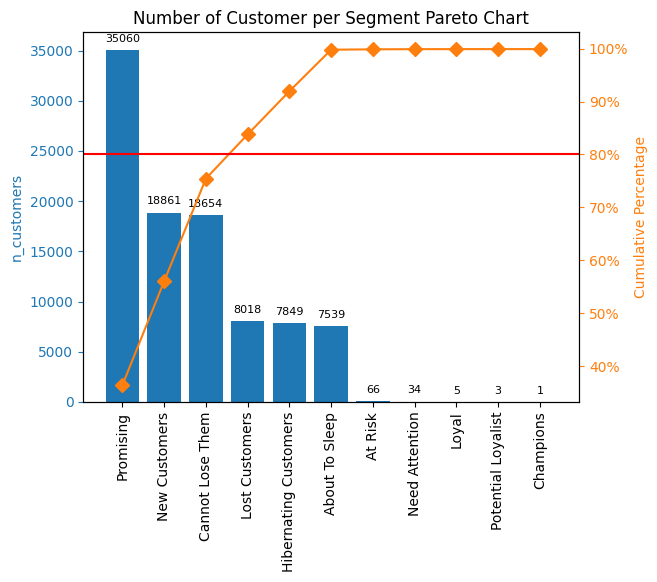

In [112]:
fig, ax = plt.subplots()
ax.bar(par.index, par["n_customers"], color="C0")
ax2 = ax.twinx()
ax2.plot(par.index, par["%_cumm"], color="C1", marker="D", ms=7)
ax2.yaxis.set_major_formatter(PercentFormatter())

# Iterating over the bars one-by-one
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')

# Iterating over the bars one-by-one
for dot in ax2.patches:
    ax2.annotate(format(dot.get_height(), '.0f'), 
                   (dot.get_x() + dot.get_width() / 2, 
                    dot.get_height()), ha='center', va='center',
                   size=8, xytext=(0, 8),
                   textcoords='offset points')


ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.tick_params(axis="x", labelrotation = 90)

ax.set_ylabel('n_customers', color='C0')
ax2.set_ylabel('Cumulative Percentage', color='C1')

plt.axhline(80, color='red')
plt.title('Number of Customer per Segment Pareto Chart')
plt.show()

Berdasarkan pareto, 75% customer olist terpusat di 3 segment: Promising (36.4%), New Customers (19.6%), dan Cannot Lose Them (19.4%)
Oleh karena itu Analisis karakteristik akan difokuskan ke 3 segment tersebut

#### **RFM**

**Recency**

In [63]:
eda_rfm.groupby(['level','RFM_segment'])['recency'].describe()

,,count,mean,std,min,25%,50%,75%,max
level,RFM_segment,,,,,,,,
0,Champions,1.0,11.000000,NaN,11.0,11.00,11.0,11.00,11.0
1,Loyal,5.0,195.800000,30.882034,149.0,185.00,199.0,220.00,226.0
2,Potential Loyalist,3.0,198.666667,36.909800,169.0,178.00,187.0,213.50,240.0
3,New Customers,18861.0,120.109167,71.625530,1.0,58.00,119.0,173.00,271.0
4,Promising,35060.0,136.480633,75.824409,2.0,72.00,136.0,199.00,271.0
5,Need Attention,34.0,206.911765,58.654286,9.0,198.25,214.0,238.25,271.0
6,About To Sleep,7539.0,273.165804,57.453190,182.0,223.00,273.0,319.00,387.0
7,Cannot Lose Them,18654.0,414.212930,94.590087,272.0,331.00,411.0,483.00,726.0
8,At Risk,66.0,382.954545,81.595142,276.0,325.00,366.5,424.50,604.0


**Frequency**

In [64]:
eda_rfm.groupby(['level','RFM_segment'])['frequency'].describe()

,,count,mean,std,min,25%,50%,75%,max
level,RFM_segment,,,,,,,,
0,Champions,1.0,17.000000,NaN,17.0,17.0,17.0,17.0,17.0
1,Loyal,5.0,6.800000,1.303840,6.0,6.0,6.0,7.0,9.0
2,Potential Loyalist,3.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
3,New Customers,18861.0,1.004401,0.066193,1.0,1.0,1.0,1.0,2.0
4,Promising,35060.0,1.055533,0.253944,1.0,1.0,1.0,1.0,5.0
5,Need Attention,34.0,3.470588,1.160859,3.0,3.0,3.0,3.0,7.0
6,About To Sleep,7539.0,1.016580,0.127702,1.0,1.0,1.0,1.0,2.0
7,Cannot Lose Them,18654.0,1.042725,0.202243,1.0,1.0,1.0,1.0,2.0
8,At Risk,66.0,3.136364,0.460313,3.0,3.0,3.0,3.0,6.0


**Monetary**

In [65]:
eda_rfm.groupby(['level','RFM_segment'])['monetary'].describe()

,,count,mean,std,min,25%,50%,75%,max
level,RFM_segment,,,,,,,,
0,Champions,1.0,927.630000,NaN,927.63,927.6300,927.630,927.6300,927.63
1,Loyal,5.0,855.502000,253.048009,540.69,660.9400,944.210,959.0100,1172.66
2,Potential Loyalist,3.0,115.080000,23.928287,87.60,106.9650,126.330,128.8200,131.31
3,New Customers,18861.0,51.671949,17.813942,0.00,37.4700,49.540,66.1300,87.54
4,Promising,35060.0,237.574162,261.714416,87.56,119.3700,163.775,244.8025,9553.02
5,Need Attention,34.0,536.529118,467.598360,136.30,240.1425,361.685,745.1450,2164.40
6,About To Sleep,7539.0,89.985152,22.206310,55.39,69.7550,87.760,107.9000,133.20
7,Cannot Lose Them,18654.0,272.343666,312.606531,87.57,139.2825,184.940,286.0900,13664.08
8,At Risk,66.0,471.046818,360.809581,110.72,259.0200,358.945,585.0900,2400.48


#### **Customer Behaviour**

**Waktu Pembelian**

In [66]:
data_segm['day_num'] = data_segm.order_purchase_timestamp.dt.weekday
data_segm['day_name'] = data_segm.order_purchase_timestamp.dt.strftime('%A')

In [67]:
day = data_segm.groupby(['RFM_segment','level','day_num','day_name'])['customer_unique_id']\
    .nunique().reset_index()\
    .rename(columns={'customer_unique_id': 'n_customers','product_category_name_english':'product'})

day['proportion_n_cust'] = day.n_customers/day.groupby(['RFM_segment'])['n_customers'].transform(sum)*100

daypiv = day.pivot_table(index=['level','RFM_segment'], columns=['day_num','day_name'], values='proportion_n_cust').sort_index(level='level', ascending=False)

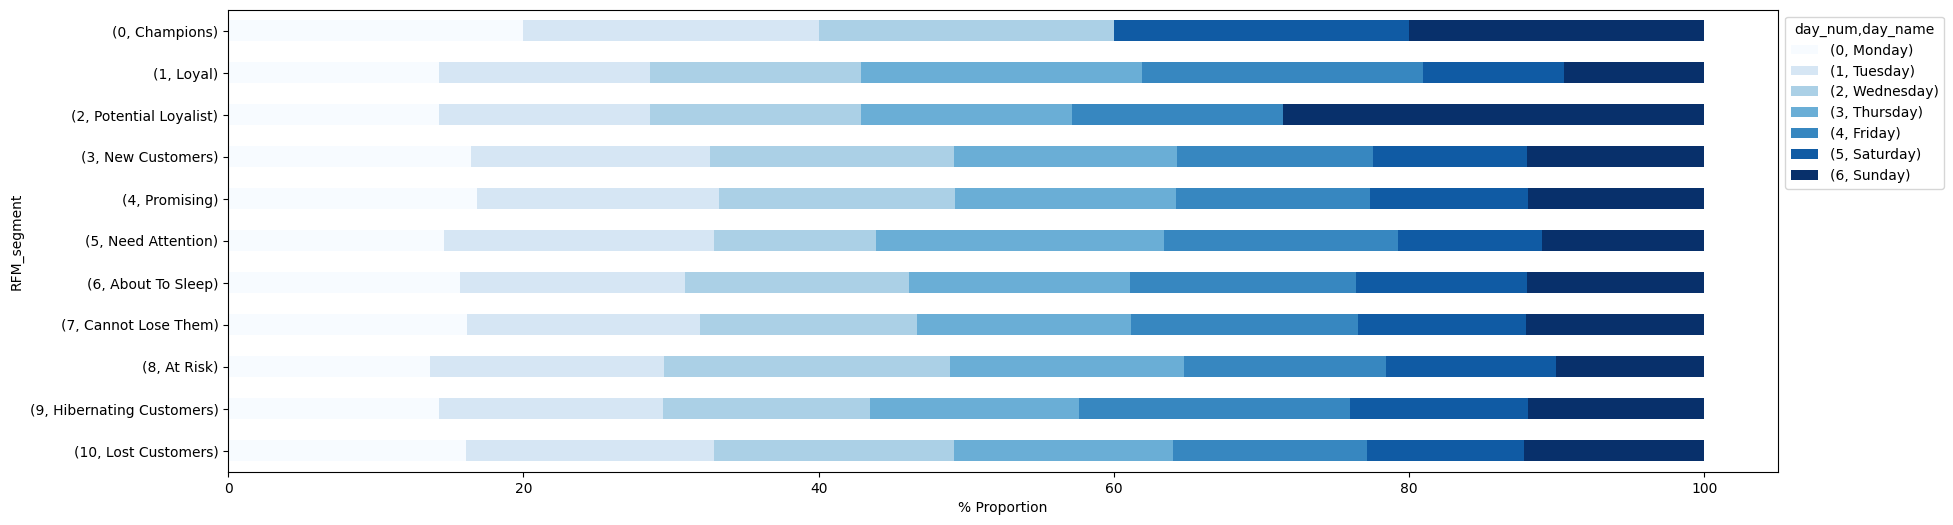

In [68]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 6))
 
# drawing the plot
daypiv.plot(kind='barh',stacked=True, colormap='Blues',rot=90, ax=ax)

ax.tick_params(axis='y', rotation=0)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlabel='% Proportion', ylabel='RFM_segment')

plt.show()

**Produk**

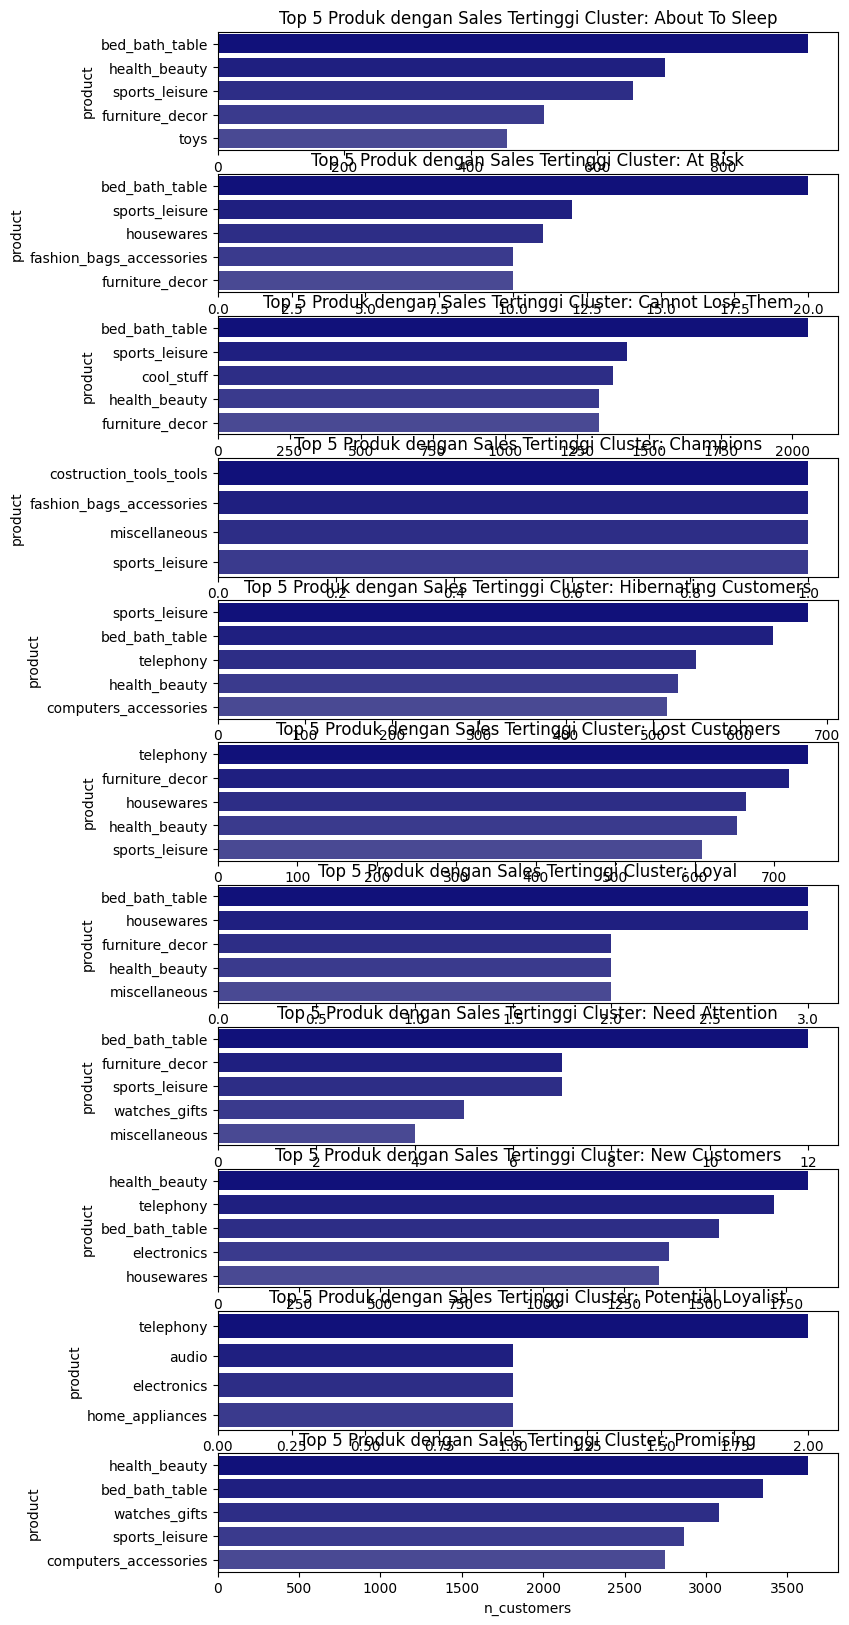

In [69]:
prod = data_segm.groupby(['RFM_segment','product_category_name_english'])['customer_unique_id'].nunique().reset_index().rename(columns={'customer_unique_id': 'n_customers','product_category_name_english':'product'})

segm = prod.RFM_segment.unique()

# Viz
c1 = sns.blend_palette(['darkblue', 'lightgrey'], 15)
fig, axes = plt.subplots(len(segm),1, figsize=(8, 20))
for i, val in enumerate(segm):
    sns.barplot(data=prod.query(f"RFM_segment == '{val}'").nlargest(5, columns='n_customers'), x = 'n_customers', y='product', palette=c1, ax=axes[i])
    axes[i].title.set_text(f'Top 5 Produk dengan Sales Tertinggi Cluster: {val}')

# plt.show()